In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import sys
import re
from collections import  OrderedDict

sys.path.insert(0 , "/Users/afinneg2/lib")
sys.path.insert(0 , "/Users/afinneg2/projects/keratinocyteRegulators")
sys.path.insert(0 , "/Users/afinneg2/projects/keratinocyteRegulators/fantomData/scripts")
from AFscripts.rnaSeqImputation import  testDE
from AFutils.visualization import  scatterPlot_colors
from AFutils.parsers.misc import  readListFromFile
import projectRC
import fantom_DE

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import  LogNorm
from matplotlib.offsetbox import  AnchoredText
from IPython.core import display as ICD
%matplotlib inline
plt.rcParams["axes.labelsize"] = "x-large"
plt.rcParams["xtick.labelsize"] =  "x-large"
plt.rcParams["ytick.labelsize"] =  "x-large"

/Users/afinneg2/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
def scatterPlot_DE( xvals ,yvals , pvals,ax ,reverseOrder = True, signifThresh = 0.1 ,
                   xLower = None, xUpper= None, yLower = None , yUpper = None,
                  title = "" ,  plotKwargs= {'alpha': 0.6}):
    
    
    colors = np.array( [ 'red' if pval < signifThresh else "black" for pval in pvals  ]  ) 
    nDE_genes = np.count_nonzero(pvals < signifThresh)
    
    finite_mask = np.isfinite(yvals)
    xvals = xvals[finite_mask].copy()
    yvals = yvals[finite_mask].copy()
    colors =  colors[finite_mask].copy()
    
    if reverseOrder :
        xvals = xvals[::-1] 
        yvals = yvals[::-1] 
        colors = colors[::-1]
    ax = scatterPlot_colors( xvals , yvals , colors,
                    ax = ax ,
                    xLower =  xLower, xUpper=  xUpper, yLower =  yLower , yUpper = yUpper, 
                   xlabel = "Mean expression Keratinocyte (tpm)" ,
                   ylabel = "log2 FC",
                   plotKwargs= plotKwargs , 
                   text = "FDR : {:.2f}\nnum DE genes : {:d}".format(signifThresh, nDE_genes),
                   title = title  )
        
    return ax

## Notebook Objective: Test modifcations of filtering by Exprssion level and foldChange in DE analysis of FANTOM data
Modifications to test:
   + Run DE tests only on set of TFs rather than on all genes
   + Require logFC of medians (kerat. vs other) > 0
   + Test minExpression thresholds of 10 , 5 , 0 TPM (10 is used tin FANTOM publication)
   
This notebook is the same as ./write-stats-TFs.tsv.ipynb except that I use FDR 0.05

In [4]:
fi_fantomExpr ="./hg19.cage_peak_phase1and2combined_tpm_allEntrez-sum.tsv"
fi_entrezToSymbol = "./entrezId_to_geneSymbol/CAGEpeaks_geneSymbol-entrezID.txt"
fi_TFs = "../Homo_sapiens_transcription_factors_gene_list-symb.txt"
fi_chromRemod = "../Homo_sapiens_chromatin_remodeling_factors_gene_list-symb.txt"
fi_TFs_Klein = "../../TF_lists/2016_PLoS_Klein/tableS2_siRNAKnockDown.txt"
fi_TFs_Klein_passSCRNA = "/Users/afinneg2/projects/keratinocyteRegulators/analysis/\
identifyRegulators/foreskin_attempt2/filter_scratch/tableS2_siRNAKnockDown_and_fore8kImputed_pass-scRNAseqFilters.txt"

In [5]:
fantomExpr = pd.read_csv(fi_fantomExpr ,sep = "\t" , index_col = 0, header = 0).transpose()
entrezToSymb_df = pd.read_csv(fi_entrezToSymbol, sep = "\t" , index_col = 1 )
TFs = pd.read_csv( fi_TFs , index_col= 0 , sep = "\t" ).index.values
chromRemod = pd.read_csv( fi_chromRemod, index_col= 0 , sep = "\t" ).index.values
TFs_Klein = readListFromFile(fi_TFs_Klein)
TFs_Klein_passSCRNA = readListFromFile(fi_TFs_Klein_passSCRNA)

#### Show the data we are working with

In [6]:
print("fantomExpr")
ICD.display(fantomExpr.head(n=3))
print("shape fantomExpr: {}\n".format(fantomExpr.shape))

print("entrezToSymb_df")
ICD.display(entrezToSymb_df.head(n=2))
print("shape entrezToSymb_df {}\n".format(entrezToSymb_df.shape))

print("TFs")
ICD.display(TFs [0:3])
print("len of TFs : {}".format(len(TFs )))

print("chromRemod")
ICD.display(TFs [0:3])
print("len of chromRemod : {}".format(len(chromRemod )))

print("TFs_Klein")
ICD.display(TFs_Klein[0:3])
print("len of TFs_Klein : {}".format(len(TFs_Klein )))

print("TFs_Klein_passSCRNA")
ICD.display(TFs_Klein_passSCRNA[0:3])
print("len of TFs_Klein_passSCRNA: {}".format(len(TFs_Klein_passSCRNA)))

fantomExpr


entrezID,1,2,9,10,12,13,14,15,16,18,...,100653247,100653286,100653301,100653327,100653339,100653515,100750247,100750325,100820829,100859930
"Adipocyte - breast, donor1-CNhs11051",50.143233,124.449690,9.265597,0.000000,14.352592,2.906854,43.239454,0.0,73.398065,3.088532,...,5.086995,70.672890,24.526581,10.355668,0.0,0.0,0.000000,0.0,0.363357,0.181678
"Adipocyte - breast, donor2-CNhs11969",23.551058,56.094337,4.067910,0.214101,86.710712,4.710212,50.527724,0.0,77.504390,4.067910,...,2.355106,733.080194,20.767751,12.203730,0.0,0.0,0.214101,0.0,6.423016,2.997407
"Adipocyte - omental, donor1-CNhs11054",26.499428,235.957672,10.289671,0.140954,94.439451,0.140954,34.533829,0.0,51.730266,5.497222,...,5.638176,425.400392,18.324073,13.672577,0.0,0.0,0.000000,0.0,0.422863,0.704772


shape fantomExpr: (495, 19088)

entrezToSymb_df


,Gene_Symbol
entrez_ID,
1,A1BG
2,A2M


shape entrezToSymb_df (18950, 1)

TFs


array(['AFF4', 'AFF2', 'AFF1'], dtype=object)

len of TFs : 1546
chromRemod


array(['AFF4', 'AFF2', 'AFF1'], dtype=object)

len of chromRemod : 128
TFs_Klein


['ATF5', 'RUNX1', 'STAT6']

len of TFs_Klein : 51
TFs_Klein_passSCRNA


['RARG', 'TP63', 'GRHL3']

len of TFs_Klein_passSCRNA: 22


### split fantomExpr into TFs (with gene symbols) , chromRemods (with geneSymbols) and other Genes (with gene symbols)

In [7]:
fantomExpr.rename(entrezToSymb_df.loc[: , "Gene_Symbol"] , axis = 1 , inplace = True )
## select TFs
TFs_inFantom =  [ x for x in TFs  if x in  fantomExpr.columns.values  ] 
print("{} of the {} TFs are in fantomExpr".format( len(TFs_inFantom) , len(TFs) ))
fantomExpr_TFs = fantomExpr.loc[: ,TFs_inFantom ].copy()

## select chromRemod
chromRemod_inFantom =  [ x for x in chromRemod if x in  fantomExpr.columns.values  ] 
print("{} of the {} chromRemod are in fantomExpr".format( len(chromRemod_inFantom) , len(chromRemod) ))
fantomExpr_chromRemod = fantomExpr.loc[: ,chromRemod_inFantom ].copy()

## select other
otherGenes_inFantom = [x for x in entrezToSymb_df.loc[: , "Gene_Symbol"].values if \
                      (x not in TFs_inFantom  ) and  (x not in  chromRemod_inFantom)  ]
print("There are {} other named genes in fantomExpr".format(len(otherGenes_inFantom)))
fantomExpr_other = fantomExpr.loc[: ,otherGenes_inFantom ].copy()


1478 of the 1546 TFs are in fantomExpr
123 of the 128 chromRemod are in fantomExpr
There are 17349 other named genes in fantomExpr


### Test different methods for calling DE on the set of TFs

In [8]:
### Split into kerat. vs other
kerat_rows_all =  [x for x in fantomExpr_TFs.index.values if \
                   re.search('Keratinocyte',  x, re.IGNORECASE ) is not None ]
kerat_rows_epidermal =  [x for x in fantomExpr_TFs.index.values if \
                         re.search('Keratinocyte - epidermal',  x, re.IGNORECASE ) is not None ]
fantomExpr_TFs_kerat_epi = fantomExpr_TFs.loc[kerat_rows_epidermal , :].copy()
fantomExpr_TFs_kerat_all = fantomExpr_TFs.loc[kerat_rows_all , :].copy()
fantomExpr_TFs_other=  fantomExpr_TFs.loc[ ~ fantomExpr_TFs.index.isin(kerat_rows_all) ,  : ].copy()


In [9]:
signifThresh = 0.05
resultsDict = OrderedDict([]) ## set up dictionary for storing results

## Do DE keratinocytes - epidermal vs other \ {keratinocyte -oral} 
+ Test various filtering criteria before calling DE

In [10]:
print("comparing {} keratinocyte data sets to {} other data sets".format(fantomExpr_TFs_kerat_epi.shape[0] , 
                                                                        fantomExpr_TFs_other.shape[0]  ))

comparing 3 keratinocyte data sets to 491 other data sets


#### Filter based on logFC of means

In [11]:
testName = "kerat-epidermal vs other: MannWhitney,logFC-mean>0,minExpr>10"
logFC_min = 0.0
minExpr_kerat = 10.0

results_df = fantom_DE.callDE_genes( group1_df  = fantomExpr_TFs_kerat_epi.copy(),
                                    group2_df  = fantomExpr_TFs_other.copy(), 
                                    group1Name = "keratinocyte" , group2Name = "other" ,
                                        signifThresh = signifThresh, 
                                        testName = "mannWhitneyU",
                                        testKwargs = {'progressUpdate': 1000 , 
                                                     "pAdj_method" :  "fdr_bh" ,
                                                    "alpha" : signifThresh,
                                                     "alternative" : "greater"},
                                        minGroup1_expr_mean = minExpr_kerat , minGroup2_expr_mean = None,
                                        minGroup1_expr_median = None , minGroup2_expr_median = None,
                                        minLog2FC_mean = logFC_min  , minLog2FC_median = None , 
                                        sortByLogFC_median = False)

nDE = np.count_nonzero( results_df.loc[: ,  "p_adj"] < signifThresh )
nExpressed = np.count_nonzero( results_df.loc[: , "avgExpr_keratinocyte"] >=  minExpr_kerat )
intersect_TFsKlein = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                         np.asarray( TFs_Klein )  ) )
intersect_TFsKein_passSCRNA = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                                 np.asarray( TFs_Klein_passSCRNA )  )
                                 )

resultsDict[testName] = { 'results_df' :  results_df , 
                         'alpha':  signifThresh , 
                         'nDE' : nDE , 
                         'minExpr_kerat' : minExpr_kerat ,
                         'nExpressed' : nExpressed ,
                         'intersect_Klein' : intersect_TFsKlein ,
                        'intersect_Klein-scRNA': intersect_TFsKein_passSCRNA }

/Users/afinneg2/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/series.py:2313: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)
/Users/afinneg2/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/series.py:2313: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)


filtering on group1_expr_mean with minimum 10.0
filtering on  minLog2FC_mean with minimum 0.0
Excluding 1320 genes from DE test
Running DE test on 158 genes
comparing groups with test mannWhitneyU


In [12]:
testName = "kerat-epidermal vs other: MannWhitney,logFC-mean>0,minExpr>5"
logFC_min = 0.0
minExpr_kerat = 5.0

results_df = fantom_DE.callDE_genes( group1_df  = fantomExpr_TFs_kerat_epi.copy(),
                                    group2_df  = fantomExpr_TFs_other.copy(), 
                                    group1Name = "keratinocyte" , group2Name = "other" ,
                                        signifThresh = signifThresh, 
                                        testName = "mannWhitneyU",
                                        testKwargs = {'progressUpdate': 1000 , 
                                                     "pAdj_method" :  "fdr_bh" ,
                                                    "alpha" : signifThresh,
                                                     "alternative" : "greater"},
                                        minGroup1_expr_mean = minExpr_kerat , minGroup2_expr_mean = None,
                                        minGroup1_expr_median = None , minGroup2_expr_median = None,
                                        minLog2FC_mean = logFC_min  , minLog2FC_median = None , 
                                        sortByLogFC_median = False)

nDE = np.count_nonzero( results_df.loc[: ,  "p_adj"] < signifThresh )
nExpressed = np.count_nonzero( results_df.loc[: , "avgExpr_keratinocyte"] >=  minExpr_kerat )
intersect_TFsKlein = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                         np.asarray( TFs_Klein )  ) )
intersect_TFsKein_passSCRNA = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                                 np.asarray( TFs_Klein_passSCRNA )  )
                                 )

resultsDict[testName] = { 'results_df' :  results_df , 
                         'alpha':  signifThresh , 
                         'nDE' : nDE , 
                         'minExpr_kerat' : minExpr_kerat ,
                         'nExpressed' : nExpressed ,
                         'intersect_Klein' : intersect_TFsKlein ,
                        'intersect_Klein-scRNA': intersect_TFsKein_passSCRNA }

/Users/afinneg2/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/series.py:2313: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)


filtering on group1_expr_mean with minimum 5.0
filtering on  minLog2FC_mean with minimum 0.0
Excluding 1271 genes from DE test
Running DE test on 207 genes
comparing groups with test mannWhitneyU


In [13]:
testName = "kerat-epidermal vs other: MannWhitney,logFC-mean>0,minExpr>0"
logFC_min = 0.0
minExpr_kerat = 0.0

results_df = fantom_DE.callDE_genes( group1_df  = fantomExpr_TFs_kerat_epi.copy(),
                                    group2_df  = fantomExpr_TFs_other.copy(), 
                                    group1Name = "keratinocyte" , group2Name = "other" ,
                                        signifThresh = signifThresh, 
                                        testName = "mannWhitneyU",
                                        testKwargs = {'progressUpdate': 1000 , 
                                                     "pAdj_method" :  "fdr_bh" ,
                                                    "alpha" : signifThresh,
                                                     "alternative" : "greater"},
                                        minGroup1_expr_mean = minExpr_kerat , minGroup2_expr_mean = None,
                                        minGroup1_expr_median = None , minGroup2_expr_median = None,
                                        minLog2FC_mean = logFC_min  , minLog2FC_median = None , 
                                        sortByLogFC_median = False)

nDE = np.count_nonzero( results_df.loc[: ,  "p_adj"] < signifThresh )
nExpressed = np.count_nonzero( results_df.loc[: , "avgExpr_keratinocyte"] >=  minExpr_kerat )
intersect_TFsKlein = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                         np.asarray( TFs_Klein )  ) )
intersect_TFsKein_passSCRNA = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                                 np.asarray( TFs_Klein_passSCRNA )  )
                                 )

resultsDict[testName] = { 'results_df' :  results_df , 
                         'alpha':  signifThresh , 
                         'nDE' : nDE , 
                         'minExpr_kerat' : minExpr_kerat ,
                         'nExpressed' : nExpressed ,
                         'intersect_Klein' : intersect_TFsKlein ,
                        'intersect_Klein-scRNA': intersect_TFsKein_passSCRNA }

/Users/afinneg2/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/series.py:2313: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)


filtering on group1_expr_mean with minimum 0.0
filtering on  minLog2FC_mean with minimum 0.0
Excluding 1195 genes from DE test
Running DE test on 283 genes
comparing groups with test mannWhitneyU


#### Filter based on logFC of medians

In [14]:
testName = "kerat-epidermal vs other: MannWhitney,logFC-med>0,minExpr>10"
logFC_min = 0.0
minExpr_kerat = 10.0

results_df = fantom_DE.callDE_genes( group1_df  = fantomExpr_TFs_kerat_epi.copy(),
                                    group2_df  = fantomExpr_TFs_other.copy(), 
                                    group1Name = "keratinocyte" , group2Name = "other" ,
                                        signifThresh = signifThresh, 
                                        testName = "mannWhitneyU",
                                        testKwargs = {'progressUpdate': 1000 , 
                                                     "pAdj_method" :  "fdr_bh" ,
                                                    "alpha" : signifThresh,
                                                     "alternative" : "greater"},
                                        minGroup1_expr_mean = minExpr_kerat , minGroup2_expr_mean = None,
                                        minGroup1_expr_median = None , minGroup2_expr_median = None,
                                        minLog2FC_mean = None  , minLog2FC_median = logFC_min, 
                                        sortByLogFC_median = True)

nDE = np.count_nonzero( results_df.loc[: ,  "p_adj"] < signifThresh )
nExpressed = np.count_nonzero( results_df.loc[: , "avgExpr_keratinocyte"] >=  minExpr_kerat )
intersect_TFsKlein = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                         np.asarray( TFs_Klein )  ) )
intersect_TFsKein_passSCRNA = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                                 np.asarray( TFs_Klein_passSCRNA )  )
                                 )

resultsDict[testName] = { 'results_df' :  results_df , 
                         'alpha':  signifThresh , 
                         'nDE' : nDE , 
                         'minExpr_kerat' : minExpr_kerat ,
                         'nExpressed' : nExpressed ,
                         'intersect_Klein' : intersect_TFsKlein ,
                        'intersect_Klein-scRNA': intersect_TFsKein_passSCRNA }

/Users/afinneg2/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/series.py:2313: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)


filtering on group1_expr_mean with minimum 10.0
filtering on minLog2FC_median with minimum 0.0
Excluding 1242 genes from DE test
Running DE test on 236 genes
comparing groups with test mannWhitneyU


In [15]:
testName = "kerat-epidermal vs other: MannWhitney,logFC-med>0,minExpr>5"
logFC_min = 0.0
minExpr_kerat = 5.0

results_df = fantom_DE.callDE_genes( group1_df  = fantomExpr_TFs_kerat_epi.copy(),
                                    group2_df  = fantomExpr_TFs_other.copy(), 
                                    group1Name = "keratinocyte" , group2Name = "other" ,
                                        signifThresh = signifThresh, 
                                        testName = "mannWhitneyU",
                                        testKwargs = {'progressUpdate': 1000 , 
                                                     "pAdj_method" :  "fdr_bh" ,
                                                    "alpha" : signifThresh,
                                                     "alternative" : "greater"},
                                        minGroup1_expr_mean = minExpr_kerat , minGroup2_expr_mean = None,
                                        minGroup1_expr_median = None , minGroup2_expr_median = None,
                                        minLog2FC_mean = None  , minLog2FC_median =logFC_min , 
                                        sortByLogFC_median = True)

nDE = np.count_nonzero( results_df.loc[: ,  "p_adj"] < signifThresh )
nExpressed = np.count_nonzero( results_df.loc[: , "avgExpr_keratinocyte"] >=  minExpr_kerat )
intersect_TFsKlein = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                         np.asarray( TFs_Klein )  ) )
intersect_TFsKein_passSCRNA = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                                 np.asarray( TFs_Klein_passSCRNA )  )
                                 )

resultsDict[testName] = { 'results_df' :  results_df , 
                         'alpha':  signifThresh , 
                         'nDE' : nDE , 
                         'minExpr_kerat' : minExpr_kerat ,
                         'nExpressed' : nExpressed ,
                         'intersect_Klein' : intersect_TFsKlein ,
                        'intersect_Klein-scRNA': intersect_TFsKein_passSCRNA }

/Users/afinneg2/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/series.py:2313: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)


filtering on group1_expr_mean with minimum 5.0
filtering on minLog2FC_median with minimum 0.0
Excluding 1181 genes from DE test
Running DE test on 297 genes
comparing groups with test mannWhitneyU


In [16]:
testName = "kerat-epidermal vs other: MannWhitney,logFC-med>0,minExpr>0"
logFC_min = 0.0
minExpr_kerat = 0.0

results_df = fantom_DE.callDE_genes( group1_df  = fantomExpr_TFs_kerat_epi.copy(),
                                    group2_df  = fantomExpr_TFs_other.copy(), 
                                    group1Name = "keratinocyte" , group2Name = "other" ,
                                        signifThresh = signifThresh, 
                                        testName = "mannWhitneyU",
                                        testKwargs = {'progressUpdate': 1000 , 
                                                     "pAdj_method" :  "fdr_bh" ,
                                                    "alpha" : signifThresh,
                                                     "alternative" : "greater"},
                                        minGroup1_expr_mean = minExpr_kerat , minGroup2_expr_mean = None,
                                        minGroup1_expr_median = None , minGroup2_expr_median = None,
                                        minLog2FC_mean = None  , minLog2FC_median =logFC_min , 
                                        sortByLogFC_median = True)

nDE = np.count_nonzero( results_df.loc[: ,  "p_adj"] < signifThresh )
nExpressed = np.count_nonzero( results_df.loc[: , "avgExpr_keratinocyte"] >=  minExpr_kerat )
intersect_TFsKlein = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                         np.asarray( TFs_Klein )  ) )
intersect_TFsKein_passSCRNA = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                                 np.asarray( TFs_Klein_passSCRNA )  )
                                 )

resultsDict[testName] = { 'results_df' :  results_df , 
                         'alpha':  signifThresh , 
                         'nDE' : nDE , 
                         'minExpr_kerat' : minExpr_kerat ,
                         'nExpressed' : nExpressed ,
                         'intersect_Klein' : intersect_TFsKlein ,
                        'intersect_Klein-scRNA': intersect_TFsKein_passSCRNA }

/Users/afinneg2/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/series.py:2313: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)


filtering on group1_expr_mean with minimum 0.0
filtering on minLog2FC_median with minimum 0.0
Excluding 1017 genes from DE test
Running DE test on 461 genes
comparing groups with test mannWhitneyU


## Do DE keratinocytes - alll vs other 
+ Test various filtering criteria before calling DE

In [17]:
print("comparing {} keratinocyte data sets to {} other data sets".format(fantomExpr_TFs_kerat_all.shape[0] , 
                                                                fantomExpr_TFs_other.shape[0]  ))

comparing 4 keratinocyte data sets to 491 other data sets


In [18]:
testName = "kerat-all vs other: MannWhitney,logFC-mean>0,minExpr>10"
logFC_min = 0.0
minExpr_kerat = 10.0

results_df = fantom_DE.callDE_genes( group1_df  = fantomExpr_TFs_kerat_all.copy(),
                                    group2_df  = fantomExpr_TFs_other.copy(), 
                                    group1Name = "keratinocyte" , group2Name = "other" ,
                                        signifThresh = signifThresh, 
                                        testName = "mannWhitneyU",
                                        testKwargs = {'progressUpdate': 1000 , 
                                                     "pAdj_method" :  "fdr_bh" ,
                                                    "alpha" : signifThresh,
                                                     "alternative" : "greater"},
                                        minGroup1_expr_mean = minExpr_kerat , minGroup2_expr_mean = None,
                                        minGroup1_expr_median = None , minGroup2_expr_median = None,
                                        minLog2FC_mean = logFC_min  , minLog2FC_median = None , 
                                        sortByLogFC_median = False)

nDE = np.count_nonzero( results_df.loc[: ,  "p_adj"] < signifThresh )
nExpressed = np.count_nonzero( results_df.loc[: , "avgExpr_keratinocyte"] >=  minExpr_kerat )
intersect_TFsKlein = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                         np.asarray( TFs_Klein )  ) )
intersect_TFsKein_passSCRNA = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                                 np.asarray( TFs_Klein_passSCRNA )  )
                                 )

resultsDict[testName] = { 'results_df' :  results_df , 
                         'alpha':  signifThresh , 
                         'nDE' : nDE , 
                         'minExpr_kerat' : minExpr_kerat ,
                         'nExpressed' : nExpressed ,
                         'intersect_Klein' : intersect_TFsKlein ,
                        'intersect_Klein-scRNA': intersect_TFsKein_passSCRNA }

/Users/afinneg2/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/series.py:2313: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)


filtering on group1_expr_mean with minimum 10.0
filtering on  minLog2FC_mean with minimum 0.0
Excluding 1315 genes from DE test
Running DE test on 163 genes
comparing groups with test mannWhitneyU


In [19]:
testName = "kerat-all vs other: MannWhitney,logFC-mean>0,minExpr>5"
logFC_min = 0.0
minExpr_kerat = 5.0

results_df = fantom_DE.callDE_genes( group1_df  = fantomExpr_TFs_kerat_all.copy(),
                                    group2_df  = fantomExpr_TFs_other.copy(), 
                                    group1Name = "keratinocyte" , group2Name = "other" ,
                                        signifThresh = signifThresh, 
                                        testName = "mannWhitneyU",
                                        testKwargs = {'progressUpdate': 1000 , 
                                                     "pAdj_method" :  "fdr_bh" ,
                                                    "alpha" : signifThresh,
                                                     "alternative" : "greater"},
                                        minGroup1_expr_mean = minExpr_kerat , minGroup2_expr_mean = None,
                                        minGroup1_expr_median = None , minGroup2_expr_median = None,
                                        minLog2FC_mean = logFC_min  , minLog2FC_median = None , 
                                        sortByLogFC_median = False)

nDE = np.count_nonzero( results_df.loc[: ,  "p_adj"] < signifThresh )
nExpressed = np.count_nonzero( results_df.loc[: , "avgExpr_keratinocyte"] >=  minExpr_kerat )
intersect_TFsKlein = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                         np.asarray( TFs_Klein )  ) )
intersect_TFsKein_passSCRNA = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                                 np.asarray( TFs_Klein_passSCRNA )  )
                                 )

resultsDict[testName] = { 'results_df' :  results_df , 
                         'alpha':  signifThresh , 
                         'nDE' : nDE , 
                         'minExpr_kerat' : minExpr_kerat ,
                         'nExpressed' : nExpressed ,
                         'intersect_Klein' : intersect_TFsKlein ,
                        'intersect_Klein-scRNA': intersect_TFsKein_passSCRNA }

/Users/afinneg2/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/series.py:2313: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)


filtering on group1_expr_mean with minimum 5.0
filtering on  minLog2FC_mean with minimum 0.0
Excluding 1247 genes from DE test
Running DE test on 231 genes
comparing groups with test mannWhitneyU


In [20]:
testName = "kerat-all vs other: MannWhitney,logFC-mean>0,minExpr>0"
logFC_min = 0.0
minExpr_kerat = 0.0

results_df = fantom_DE.callDE_genes( group1_df  = fantomExpr_TFs_kerat_all.copy(),
                                    group2_df  = fantomExpr_TFs_other.copy(), 
                                    group1Name = "keratinocyte" , group2Name = "other" ,
                                        signifThresh = signifThresh, 
                                        testName = "mannWhitneyU",
                                        testKwargs = {'progressUpdate': 1000 , 
                                                     "pAdj_method" :  "fdr_bh" ,
                                                    "alpha" : signifThresh,
                                                     "alternative" : "greater"},
                                        minGroup1_expr_mean = minExpr_kerat , minGroup2_expr_mean = None,
                                        minGroup1_expr_median = None , minGroup2_expr_median = None,
                                        minLog2FC_mean = logFC_min  , minLog2FC_median = None , 
                                        sortByLogFC_median = False)

nDE = np.count_nonzero( results_df.loc[: ,  "p_adj"] < signifThresh )
nExpressed = np.count_nonzero( results_df.loc[: , "avgExpr_keratinocyte"] >=  minExpr_kerat )
intersect_TFsKlein = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                         np.asarray( TFs_Klein )  ) )
intersect_TFsKein_passSCRNA = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                                 np.asarray( TFs_Klein_passSCRNA )  )
                                 )

resultsDict[testName] = { 'results_df' :  results_df , 
                         'alpha':  signifThresh , 
                         'nDE' : nDE , 
                         'minExpr_kerat' : minExpr_kerat ,
                         'nExpressed' : nExpressed ,
                         'intersect_Klein' : intersect_TFsKlein ,
                        'intersect_Klein-scRNA': intersect_TFsKein_passSCRNA }

/Users/afinneg2/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/series.py:2313: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)


filtering on group1_expr_mean with minimum 0.0
filtering on  minLog2FC_mean with minimum 0.0
Excluding 1153 genes from DE test
Running DE test on 325 genes
comparing groups with test mannWhitneyU


#### Filter based on logFC of medians



In [21]:
testName = "kerat-all vs other: MannWhitney,logFC-med>0,minExpr>10"
logFC_min = 0.0
minExpr_kerat = 10.0

results_df = fantom_DE.callDE_genes( group1_df  = fantomExpr_TFs_kerat_all.copy(),
                                    group2_df  = fantomExpr_TFs_other.copy(), 
                                    group1Name = "keratinocyte" , group2Name = "other" ,
                                        signifThresh = signifThresh, 
                                        testName = "mannWhitneyU",
                                        testKwargs = {'progressUpdate': 1000 , 
                                                     "pAdj_method" :  "fdr_bh" ,
                                                    "alpha" : signifThresh,
                                                     "alternative" : "greater"},
                                        minGroup1_expr_mean = minExpr_kerat , minGroup2_expr_mean = None,
                                        minGroup1_expr_median = None , minGroup2_expr_median = None,
                                        minLog2FC_mean = None  , minLog2FC_median = logFC_min, 
                                        sortByLogFC_median = True)

nDE = np.count_nonzero( results_df.loc[: ,  "p_adj"] < signifThresh )
nExpressed = np.count_nonzero( results_df.loc[: , "avgExpr_keratinocyte"] >=  minExpr_kerat )
intersect_TFsKlein = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                         np.asarray( TFs_Klein )  ) )
intersect_TFsKein_passSCRNA = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                                 np.asarray( TFs_Klein_passSCRNA )  )
                                 )

resultsDict[testName] = { 'results_df' :  results_df , 
                         'alpha':  signifThresh , 
                         'nDE' : nDE , 
                         'minExpr_kerat' : minExpr_kerat ,
                         'nExpressed' : nExpressed ,
                         'intersect_Klein' : intersect_TFsKlein ,
                        'intersect_Klein-scRNA': intersect_TFsKein_passSCRNA }

/Users/afinneg2/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/series.py:2313: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)


filtering on group1_expr_mean with minimum 10.0
filtering on minLog2FC_median with minimum 0.0
Excluding 1230 genes from DE test
Running DE test on 248 genes
comparing groups with test mannWhitneyU


In [22]:
testName = "kerat-all vs other: MannWhitney,logFC-med>0,minExpr>5"
logFC_min = 0.0
minExpr_kerat = 5.0

results_df = fantom_DE.callDE_genes( group1_df  = fantomExpr_TFs_kerat_all.copy(),
                                    group2_df  = fantomExpr_TFs_other.copy(), 
                                    group1Name = "keratinocyte" , group2Name = "other" ,
                                        signifThresh = signifThresh, 
                                        testName = "mannWhitneyU",
                                        testKwargs = {'progressUpdate': 1000 , 
                                                     "pAdj_method" :  "fdr_bh" ,
                                                    "alpha" : signifThresh,
                                                     "alternative" : "greater"},
                                        minGroup1_expr_mean = minExpr_kerat , minGroup2_expr_mean = None,
                                        minGroup1_expr_median = None , minGroup2_expr_median = None,
                                        minLog2FC_mean = None  , minLog2FC_median =logFC_min , 
                                        sortByLogFC_median = True)

nDE = np.count_nonzero( results_df.loc[: ,  "p_adj"] < signifThresh )
nExpressed = np.count_nonzero( results_df.loc[: , "avgExpr_keratinocyte"] >=  minExpr_kerat )
intersect_TFsKlein = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                         np.asarray( TFs_Klein )  ) )
intersect_TFsKein_passSCRNA = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                                 np.asarray( TFs_Klein_passSCRNA )  )
                                 )

resultsDict[testName] = { 'results_df' :  results_df , 
                         'alpha':  signifThresh , 
                         'nDE' : nDE , 
                         'minExpr_kerat' : minExpr_kerat ,
                         'nExpressed' : nExpressed ,
                         'intersect_Klein' : intersect_TFsKlein ,
                        'intersect_Klein-scRNA': intersect_TFsKein_passSCRNA }

/Users/afinneg2/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/series.py:2313: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)


filtering on group1_expr_mean with minimum 5.0
filtering on minLog2FC_median with minimum 0.0
Excluding 1145 genes from DE test
Running DE test on 333 genes
comparing groups with test mannWhitneyU


In [23]:
testName = "kerat-all vs other: MannWhitney,logFC-med>0,minExpr>0"
logFC_min = 0.0
minExpr_kerat = 0.0

results_df = fantom_DE.callDE_genes( group1_df  = fantomExpr_TFs_kerat_all.copy(),
                                    group2_df  = fantomExpr_TFs_other.copy(), 
                                    group1Name = "keratinocyte" , group2Name = "other" ,
                                        signifThresh = signifThresh, 
                                        testName = "mannWhitneyU",
                                        testKwargs = {'progressUpdate': 1000 , 
                                                     "pAdj_method" :  "fdr_bh" ,
                                                    "alpha" : signifThresh,
                                                     "alternative" : "greater"},
                                        minGroup1_expr_mean = minExpr_kerat , minGroup2_expr_mean = None,
                                        minGroup1_expr_median = None , minGroup2_expr_median = None,
                                        minLog2FC_mean = None  , minLog2FC_median =logFC_min , 
                                        sortByLogFC_median = True)

nDE = np.count_nonzero( results_df.loc[: ,  "p_adj"] < signifThresh )
nExpressed = np.count_nonzero( results_df.loc[: , "avgExpr_keratinocyte"] >=  minExpr_kerat )
intersect_TFsKlein = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                         np.asarray( TFs_Klein )  ) )
intersect_TFsKein_passSCRNA = len(np.intersect1d( results_df.loc[results_df.loc[: ,  "p_adj"] < signifThresh, : ].index ,
                                                 np.asarray( TFs_Klein_passSCRNA )  )
                                 )

resultsDict[testName] = { 'results_df' :  results_df , 
                         'alpha':  signifThresh , 
                         'nDE' : nDE , 
                         'minExpr_kerat' : minExpr_kerat ,
                         'nExpressed' : nExpressed ,
                         'intersect_Klein' : intersect_TFsKlein ,
                        'intersect_Klein-scRNA': intersect_TFsKein_passSCRNA }

/Users/afinneg2/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/series.py:2313: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)


filtering on group1_expr_mean with minimum 0.0
filtering on minLog2FC_median with minimum 0.0
Excluding 931 genes from DE test
Running DE test on 547 genes
comparing groups with test mannWhitneyU


In [24]:
for key in resultsDict.keys():
    print(key)
    print("nDE:  {}".format(resultsDict[key]["nDE"]) )
    print("magnitude intersection TF_Klein:  {}".format(resultsDict[key]["intersect_Klein"]) )
    print("magnitude intersection TF_Klein and pass scRNAseq filter: {}".format( resultsDict[key]["intersect_Klein-scRNA"] ))
    print("\n")

kerat-epidermal vs other: MannWhitney,logFC-mean>0,minExpr>10
nDE:  41
magnitude intersection TF_Klein:  4
magnitude intersection TF_Klein and pass scRNAseq filter: 4


kerat-epidermal vs other: MannWhitney,logFC-mean>0,minExpr>5
nDE:  43
magnitude intersection TF_Klein:  6
magnitude intersection TF_Klein and pass scRNAseq filter: 5


kerat-epidermal vs other: MannWhitney,logFC-mean>0,minExpr>0
nDE:  68
magnitude intersection TF_Klein:  7
magnitude intersection TF_Klein and pass scRNAseq filter: 6


kerat-epidermal vs other: MannWhitney,logFC-med>0,minExpr>10
nDE:  27
magnitude intersection TF_Klein:  3
magnitude intersection TF_Klein and pass scRNAseq filter: 3


kerat-epidermal vs other: MannWhitney,logFC-med>0,minExpr>5
nDE:  33
magnitude intersection TF_Klein:  5
magnitude intersection TF_Klein and pass scRNAseq filter: 4


kerat-epidermal vs other: MannWhitney,logFC-med>0,minExpr>0
nDE:  49
magnitude intersection TF_Klein:  6
magnitude intersection TF_Klein and pass scRNAseq filte

In [27]:
candidateGeneList_Jun= ["IRX4" , "TP63" , "GRHL3" , "FOSL1", "KLF5" , "VDR" , "CERS3"]

In [29]:
for testName,  results  in resultsDict.items():
    results_df = results["results_df"]
    signifThresh = results["alpha"]
    results_df_candid = results_df.loc[ candidateGeneList_Jun ].copy()
    results_df_candid["selected"] = results_df_candid.loc[: , "p_adj"  ] <  signifThresh
    print(testName)
    print("{} of {} candidate Genes pass".format(np.count_nonzero(results_df_candid.loc[: , "selected"].values ),
                                                 results_df_candid.loc[: , "selected"].shape[0]) )
    

kerat-epidermal vs other: MannWhitney,logFC-mean>0,minExpr>10
7 of 7 candidate Genes pass
kerat-epidermal vs other: MannWhitney,logFC-mean>0,minExpr>5
7 of 7 candidate Genes pass
kerat-epidermal vs other: MannWhitney,logFC-mean>0,minExpr>0
7 of 7 candidate Genes pass
kerat-epidermal vs other: MannWhitney,logFC-med>0,minExpr>10
5 of 7 candidate Genes pass
kerat-epidermal vs other: MannWhitney,logFC-med>0,minExpr>5
5 of 7 candidate Genes pass
kerat-epidermal vs other: MannWhitney,logFC-med>0,minExpr>0
5 of 7 candidate Genes pass
kerat-all vs other: MannWhitney,logFC-mean>0,minExpr>10
6 of 7 candidate Genes pass
kerat-all vs other: MannWhitney,logFC-mean>0,minExpr>5
7 of 7 candidate Genes pass
kerat-all vs other: MannWhitney,logFC-mean>0,minExpr>0
7 of 7 candidate Genes pass
kerat-all vs other: MannWhitney,logFC-med>0,minExpr>10
6 of 7 candidate Genes pass
kerat-all vs other: MannWhitney,logFC-med>0,minExpr>5
7 of 7 candidate Genes pass
kerat-all vs other: MannWhitney,logFC-med>0,minExpr>

### Choose a set of filtering parameters that give good overlap with TFs in Klein and  passing scRNA-seq filters but not too many DE genes overall. 

Want:
    1. maximum overlap with list of Klein TFs
    2. maximum overlap with list of genes to which Jun has assigned function
    3. not too many TFs overall

Based on criteria 1, 2 consider
+ the choice  **kerat-epidermal vs other: MannWhitney,logFC-mean>0,minExpr>0** gives overlap of 6 and total of  68 DE genes ( 107 DE genes at 0.1 FDR )
+ the choice **kerat-all vs other: MannWhitney,logFC-mean>0,minExpr>0** gives  overlap of  6 and total of 98 DE genes (123 DE genes at 0.1 FDR)
+ Also write **kerat-epidermal vs other: MannWhitney,logFC-mean>0,minExpr>10**

These are alos reasonable choices in that they contain all contain all 7 of Jun's candidate genes

In [30]:
fo_dict = {"kerat-epidermal vs other: MannWhitney,logFC-mean>0,minExpr>0": \
           "fantomDE-TF_keratEpiderm-logFCMean-minExpr0-FDR0.05.stats.tsv",
           
          "kerat-all vs other: MannWhitney,logFC-mean>0,minExpr>0" :  \
           "fantomDE-TF_keratAll-logFCMean-minExpr0-FDR0.05.stats.tsv",
           
          "kerat-epidermal vs other: MannWhitney,logFC-mean>0,minExpr>10" : \
           "fantomDE-TF_keratEpiderm-logFCMean-minExpr10-FDR0.05.stats.tsv"
          }
           
for key , fo in fo_dict.items():
    results_df = resultsDict[key]['results_df']
    results_df.to_csv( fo  )

/Users/afinneg2/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


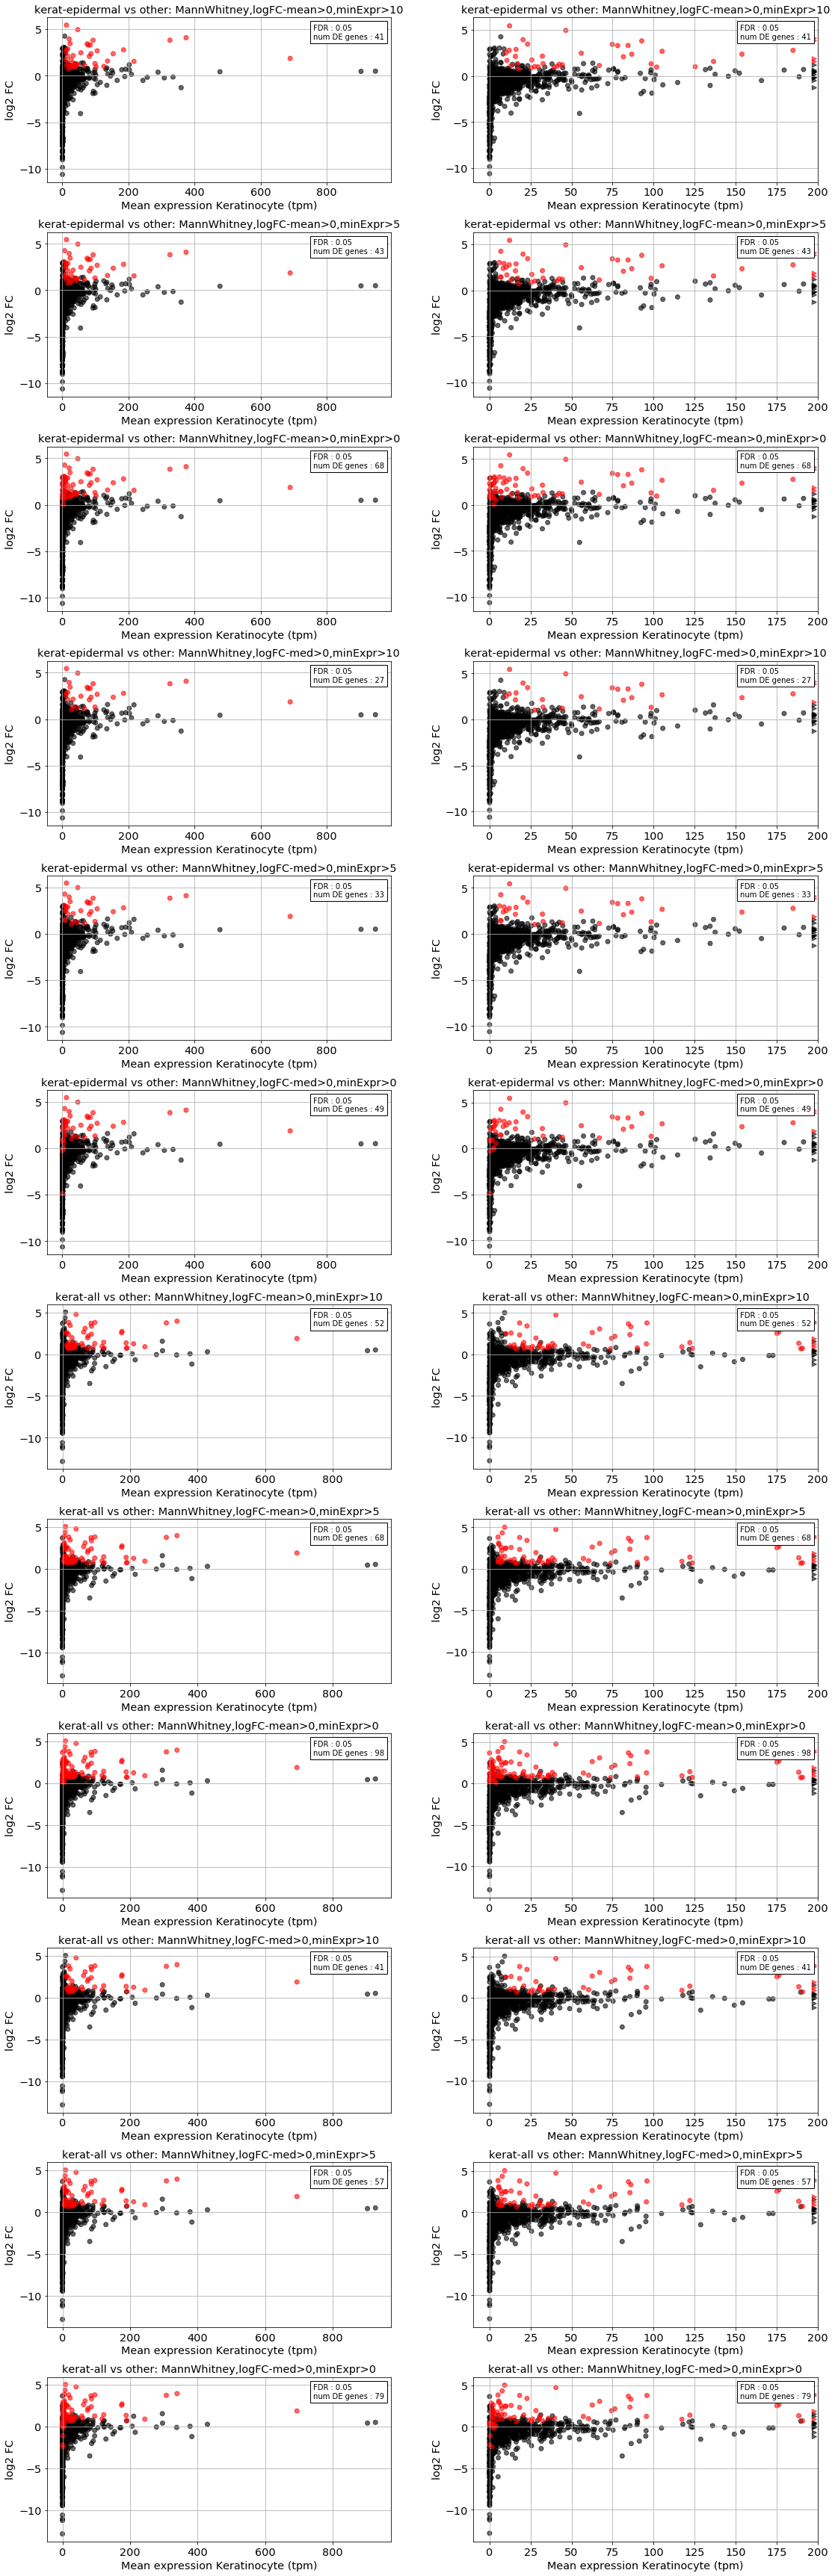

In [31]:
ncols = 2
axHeigth = 4
figWidth = 16
xUpper = 200

###########
nrows = len(resultsDict.keys())
fig , axes = plt.subplots(figsize = (figWidth , axHeigth*nrows) , nrows = nrows , ncols = ncols)
axes_iter = iter(np.ravel(axes))


for testName,  results  in resultsDict.items():
    ax  = next(axes_iter)
    results_df = results['results_df']
    signifThresh = results["alpha"]
    
    ax = scatterPlot_DE( xvals =  results_df.loc[: , "avgExpr_keratinocyte"].values  ,
                   yvals  = results_df.loc[ : , 'logFC'].values, 
                   pvals = results_df.loc[ : , 'p_adj'].values,
                   ax = ax,
                   reverseOrder = True, signifThresh = signifThresh ,
                   xLower = None, xUpper= None, yLower = None , yUpper = None,
                    title = testName ,  plotKwargs= {'alpha': 0.6})
    
    ax = next(axes_iter)
    
    ax = scatterPlot_DE( xvals =  results_df.loc[: , "avgExpr_keratinocyte"].values  ,
                   yvals  = results_df.loc[ : , 'logFC'].values, 
                   pvals = results_df.loc[ : , 'p_adj'].values,
                   ax = ax,
                   reverseOrder = True, signifThresh =  signifThresh  ,
                   xLower = None, xUpper= xUpper, yLower = None , yUpper = None,
                    title = testName ,  plotKwargs= {'alpha': 0.6})
    
fig.tight_layout()